# Handlers

Esta tabla contiene la información adicional de las sentencias Try/TryStar. --> ABEL COMPLETAR <--

## 1 - Obtencion de datos

In [1]:
import matplotlib.pyplot as plt
from notebooks_utils import *

full_table = get_data('handlers')

# Table name, features and target.
TABLE_NAME = 'handlers'
TABLE_FEATURES = ['handler__number_of_handlers', 'handler__has_star', 'handler__has_finally', 'handler__has_catch_all', 'handler__average_body_count', 'handler__expertise_level']
TABLE_TARGET = 'handler__expertise_level'

# Load features and target.
X, y = full_table[TABLE_FEATURES], full_table[[TABLE_TARGET]].iloc[:,0]

# Print information about the loaded table.
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

print(f'As we can see the downloaded data contains a total of {X.shape[0]} instances. Each of the instances corresponds to a program. For each program we have {X.shape[1]} attributes.')

2024-05-14 18:18:04.023136 Loading data ...
2024-05-14 18:18:04.821973 Data successfully load!!
2024-05-14 18:18:04.821973 Creating data cache files ...
2024-05-14 18:18:04.825971 Data cache files successfully created!!
Features shape: (15199, 6)
Target shape: (15199,)
As we can see the downloaded data contains a total of 15199 instances. Each of the instances corresponds to a program. For each program we have 6 attributes.


## 2 - Exploracion de datos

Una vez tenemos nuestra tabla en un dataframe el siguiente paso es explorarla para ver qué tipo de información contiene.

In [2]:
print(X.info())
print('=============')
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15199 entries, 0 to 15198
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   handler__number_of_handlers  15199 non-null  int64  
 1   handler__has_star            15199 non-null  bool   
 2   handler__has_finally         15199 non-null  bool   
 3   handler__has_catch_all       15199 non-null  bool   
 4   handler__average_body_count  15199 non-null  float64
 5   handler__expertise_level     15199 non-null  object 
dtypes: bool(3), float64(1), int64(1), object(1)
memory usage: 400.9+ KB
None
<class 'pandas.core.series.Series'>
RangeIndex: 15199 entries, 0 to 15198
Series name: handler__expertise_level
Non-Null Count  Dtype 
--------------  ----- 
15199 non-null  object
dtypes: object(1)
memory usage: 118.9+ KB
None


Cómo podemos ver la tabla está compuesta por 2 variables numéricas, 3 de tipo boleano  y una de tipo objeto. Esta última variable es la clase con la que se ha etiquetado la instancia. Sin embargo, en algunas ocasiones esta última clase no la vamos a utilizar. Por ejemplo, si queremos obtener clusters por medio de aprendizaje no supervisado.

### 2.1 - Balance de clases

In [3]:
instances_for_class_low = len(full_table[full_table[TABLE_TARGET] == "BEGINNER"])
instances_for_class_high = len(full_table[full_table[TABLE_TARGET] == "EXPERT"])

print(f"The dataset contains {instances_for_class_low/len(full_table)*100:.4}% instances for BEGINNER class and {instances_for_class_high/len(full_table)*100:.4}% for EXPERT class.")

The dataset contains 56.96% instances for BEGINNER class and 43.04% for EXPERT class.


### 2.2 - Duplicados
Miramos si la tabla tiene entradas duplicadas.

In [4]:
number_of_duplicated_entries = sum(full_table.duplicated(subset=TABLE_FEATURES + [TABLE_TARGET]))
duplicated_entries_pct = number_of_duplicated_entries / len(full_table) * 100
print(f"The dataset contains [{duplicated_entries_pct:.4}%] of duplicated entries.")

The dataset contains [99.22%] of duplicated entries.


### 2.3 - Valores Nulos 
Miramos si alguna de las variables que contiene la tabla contiene algún valor que sea nulo.

In [5]:
X.isnull().sum()

handler__number_of_handlers    0
handler__has_star              0
handler__has_finally           0
handler__has_catch_all         0
handler__average_body_count    0
handler__expertise_level       0
dtype: int64

Aunque una columna no contenga valores nulos podría ser que contenga valores vacíos. Si los hubiese la siguiente función los mostraría.

In [6]:
print_empty_cols(X)

handler__number_of_handlers
---------------------------
0 instancias no tienen un valor para la columna handler__number_of_handlers


handler__has_star
-----------------
0 instancias no tienen un valor para la columna handler__has_star


handler__has_finally
--------------------
0 instancias no tienen un valor para la columna handler__has_finally


handler__has_catch_all
----------------------
0 instancias no tienen un valor para la columna handler__has_catch_all


handler__average_body_count
---------------------------
0 instancias no tienen un valor para la columna handler__average_body_count


handler__expertise_level
------------------------
0 instancias no tienen un valor para la columna handler__expertise_level




### 2.4 - Describimos los valores de las variables de la tabla.

In [7]:
np.transpose(X.describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
handler__number_of_handlers,15199.0,NaN,NaN,NaN,0.99671,0.465823,0.0,1.0,1.0,1.0,9.0
handler__has_star,15199,1,False,15199,NaN,NaN,NaN,NaN,NaN,NaN,NaN
handler__has_finally,15199,2,False,13904,NaN,NaN,NaN,NaN,NaN,NaN,NaN
handler__has_catch_all,15199,2,False,14404,NaN,NaN,NaN,NaN,NaN,NaN,NaN
handler__average_body_count,15199.0,NaN,NaN,NaN,1.281247,0.870314,0.0,1.0,1.0,1.0,15.0
handler__expertise_level,15199,2,BEGINNER,8658,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Hay try con un numero medio de sentencias en los bodies de 0? Un try vacio? La indentacion de python suele impedirlo

Vamos a discretizar las variables numericas, agrupando conjuntos de valores en categorias, para hacer un análisis de los datos. Para cada variable es necesaario ver la distribucion de lo valores para hacer los bins (categorias).

In [8]:
# DISCRETIZATION
X_copy = X.copy()

discretized_columns = {
    "handler__number_of_handlers": [(0.0, 1.0), (1.0, 1.0), (1.0, inf)],  # min: 0.0 max: 9.0 
    "handler__average_body_count": [(0.0, 1.0), (1.0, 1.0), (1.0, inf)],  # min: 0.0 max: 15.0 
}

discretize_columns(X_copy, discretized_columns)
    
# SINGLE FEATURE
print("--- SINGLE FEATURE ---")
print(get_statistics(X_copy, ['handler__number_of_handlers'], 10))
print(get_statistics(X_copy, ['handler__average_body_count'], 10))
print(get_statistics(X_copy, ['handler__has_star'], 10))
print(get_statistics(X_copy, ['handler__has_finally'], 10))
print(get_statistics(X_copy, ['handler__has_catch_all'], 10))

# 2 FEATURES
print("--- TWO FEATURES ---")
#print(get_statistics(X_copy, ['import__average_imported_modules', 'import__module_imports_pct'], 10))

# 3 FEATURES
print("--- THREE FEATURES ---")
#print(get_statistics(X_copy, ['program__has_sub_dirs_with_code', 'program__has_packages', 'program__has_code_root_package'], 10))

--- SINGLE FEATURE ---
handler__number_of_handlers  count  percentage
                  [1.0_1.0]  13434   88.387394
                  [0.0_1.0)   1070    7.039937
                  [1.0_inf]    695    4.572669

handler__average_body_count  count  percentage
                  [1.0_1.0]  10404   68.451872
                  [1.0_inf]   3725   24.508191
                  [0.0_1.0)   1070    7.039937

 handler__has_star  count  percentage
             False  15199       100.0

 handler__has_finally  count  percentage
                False  13904   91.479703
                 True   1295    8.520297

 handler__has_catch_all  count  percentage
                  False  14404   94.769393
                   True    795    5.230607

--- TWO FEATURES ---
--- THREE FEATURES ---


No se usa el tryStar?

In [9]:
def normalize_datatypes(X:pd.DataFrame, y:pd.Series) -> (pd.DataFrame, pd.Series, [str]):
    X = pd.get_dummies(X)
    X = X.astype('float32')
    y = y.apply(lambda value: 0 if value == "BEGINNER" else 1) # EXPERT will be 1 and BEGINNER will be 0.
    y = y.astype('float32')
    columns_names = X.columns.tolist()
    return X, y, columns_names

X, y, TABLE_FEATURES = normalize_datatypes(X, y)
# Print information about the loaded table
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Features shape: (15199, 7)
Target shape: (15199,)


#### Muestra la matriz de correlación de pearson entre las variables de la tabla.

<Axes: >

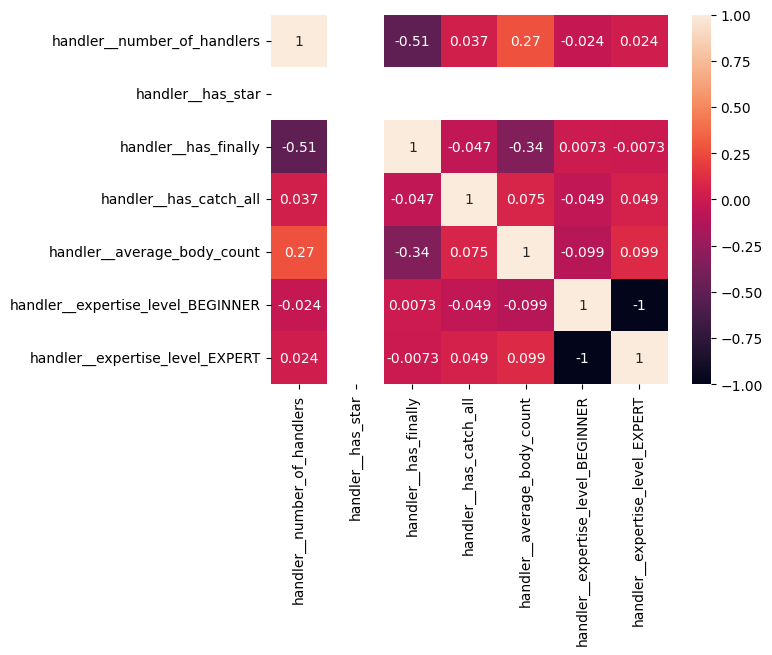

In [10]:
sns.heatmap(X.corr(), annot=True)

## 3 - Detección de valores atípicos (outliers)
Una vez sabemos qué datos contiene la tabla, analizaremos los valores que toma cada una de las variables de cada instancia. El objetivo es identificar posibles valores atípicos que nos dificulten la realización de futuras tareas. 
Tras su análisis, se puede concluir que un valor:
    - **Es erróneo**. En este caso hay que tomar una decisión para cada caso, siendo los tratamientos más extendidos son listwise, pairwise, drop variables, mean/median imputation, most frequent, separate category, zero imputation, cold deck, hot deck,(stochastic) regression, k-NN and multiple imputation. Los resultados de imputación regresiva, k-NN y múltiple dan buenos resultados, aunque, como se ha indicado, es necesario el estudio en cada caso.
    - **Es correcto, pero anómalo**. Se documenta su existencia para su posible discusión y se mantiene en el dataset. En estos casos se hace necesaria la utilización de algoritmos y estadísticos que no sean muy sensibles a dichos valores anómalos.

## Univariate
Para cada uno de los atributos se debe realizar un análisis y detección de valores atípicos, estudiando su posible causa. 
Existen diversas formas de calcular los valores anómalos. 

### Variables numéricas
Para las variables numéricas, se suele identificar: 
    - a) Valor atípico leve es el que está fuera de $[Q1 - 1.5IQR, Q3 + 1.5IQR]$, donde $IQR = Q3-Q1$.
    - b) Valor atípico extremo está fuera de $[Q1 - 3IQR, Q3 + 3IQR]$.

La idea es probar con a) y si hay pocas instancias analizarlas. Si hubiese muchas, mirar b) y analizar si fuesen pocas. No hay un algoritmo o método estipulado, puesto que depende del dominio del problema y de los datos.

Los límites de Tukey se basan en los cuartiles de los datos y son sensibles a la presencia de sesgo en la distribución. Cuando hay asimetría en los datos, los límites de Tukey pueden no ser tan efectivos para identificar outliers de manera equitativa en ambos extremos de la distribución. El Coeficiente de Medcouple es útil para identificar la asimetría en los datos, especialmente en presencia de valores atípicos o sesgados. Es una medida robusta porque no se ve tan afectada por valores extremos como la media y la desviación estándar. El MC puede proporcionar información adicional sobre la asimetría de la distribución, lo que te permite ajustar los límites de Tukey de manera más apropiada para tu conjunto de datos específico. Una posible variacion de los límites de Tukey teniendo en cuenta MC podria ser: 
   - Si MC es mayor que 0 (asimetría hacia la derecha):
      - low = (q1-1.5 * math.exp(-4*mc) * iqr)
      - high = (q3+1.5 * math.exp(3.5*mc) * iqr)
   - Si la asimetriza es hacia la izquierda:    
      - low = (q1-1.5 * math.exp(-3.5*mc) * iqr)
      - high = (q3+1.5 * math.exp(4*mc) * iqr)


### Variables categóricas
Para las variables categóricas no existe el concepto de valor anómalo, pero sí se puede considerar en base a un análisis de frecuencia. Por ejemplo, que el uso de una categoría sea residual, pudiendo tener un 0.1% de instancias en el dataset. Para detectar estos valores, se puede fijar un valor mínimo de frecuencia en función del número posible de valores de la variable categórica (2 en el caso de una variable booleana). Por ejemplo, un umbral de $\frac{0.2\%}{valores}$ (0.1% en el caso de una variable booleana)

## Analisis detallado de variables
Para cada una de las 5 variable (2 numéricas y 3 boleanas) se hara un analisis detallado 

### Variable number_of_handlers (1/5)
Esta variable es de tipo numérica y nos indica el número de clausulas except en la sentencia Try. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 0 - 9. Con una media de 0.99.

<Axes: ylabel='handler__number_of_handlers'>

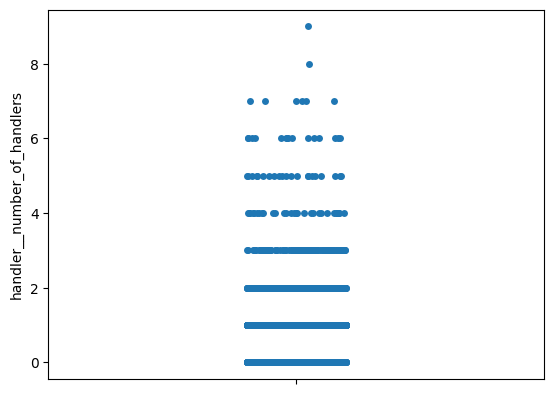

In [11]:
sns.stripplot(X['handler__number_of_handlers'])

In [12]:
print_outliers_for_df_column(X, 'handler__number_of_handlers')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.3888888888888889
Rango valores atípicos extremos (Tukey): [1.0,1.0]
Rango valores atípicos leves (Tukey): [1.0,1.0]
Rango valores atípicos extremos (Fixed BoxPlot): [1.0,1.0]
-3.0IQR: 1070 instancias tienen un valor para handler__number_of_handlers inferior a 1.0 (Q1-3*IQR) para handler__number_of_handlers. Representando un 7.04% del total de instancias.
-1.5IQR: 1070 instancias tienen un valor para handler__number_of_handlers inferior a 1.0 (Q1-1.5*IQR) para handler__number_of_handlers. Representando un 7.04% del total de instancias.
+1.5IQR: 695 instancias tienen un valor para handler__number_of_handlers superior a 1.0 (Q3+1.5*IQR) para handler__number_of_handlers. Representando un 4.573% del total de instancias.
+3.0IQR: 695 instancias tienen un valor para handler__number_of_handlers superior a 1.0 (Q3-3*IQR) para handler__number_of_handlers. Representando un 4.573% del total de instancias.
L: 1070 instancias tienen un valo

In [13]:
X[X['handler__number_of_handlers'] > 1].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,handler__number_of_handlers,handler__has_star,handler__has_finally,handler__has_catch_all,handler__average_body_count,handler__expertise_level_BEGINNER,handler__expertise_level_EXPERT
count,695.000000,695.0,695.000000,695.000000,695.000000,695.000000,695.000000
mean,2.467626,0.0,0.054676,0.060432,1.570748,0.523741,0.476259
std,1.026326,0.0,0.227511,0.238456,0.915384,0.499796,0.499796
min,2.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000
50%,2.000000,0.0,0.000000,0.000000,1.333333,1.000000,0.000000
75%,2.000000,0.0,0.000000,0.000000,1.666667,1.000000,1.000000
max,9.000000,0.0,1.000000,1.000000,9.500000,1.000000,1.000000


### Variable average_body_count (2/5)
Esta variable representa el número medio de sentencias en los cuerpos del try y los except. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 0 - 0. Con una media de 1.28.

<Axes: ylabel='handler__average_body_count'>

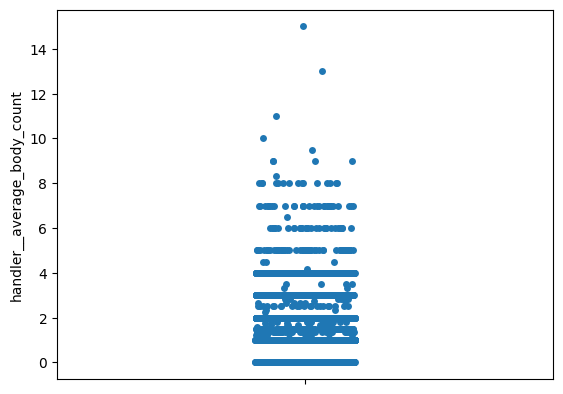

In [14]:
sns.stripplot(X['handler__average_body_count'])

In [15]:
print_outliers_for_df_column(X, 'handler__average_body_count')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.9241551020887742
Rango valores atípicos extremos (Tukey): [1.0,1.0]
Rango valores atípicos leves (Tukey): [1.0,1.0]
Rango valores atípicos extremos (Fixed BoxPlot): [1.0,1.0]
-3.0IQR: 1070 instancias tienen un valor para handler__average_body_count inferior a 1.0 (Q1-3*IQR) para handler__average_body_count. Representando un 7.04% del total de instancias.
-1.5IQR: 1070 instancias tienen un valor para handler__average_body_count inferior a 1.0 (Q1-1.5*IQR) para handler__average_body_count. Representando un 7.04% del total de instancias.
+1.5IQR: 3725 instancias tienen un valor para handler__average_body_count superior a 1.0 (Q3+1.5*IQR) para handler__average_body_count. Representando un 24.51% del total de instancias.
+3.0IQR: 3725 instancias tienen un valor para handler__average_body_count superior a 1.0 (Q3-3*IQR) para handler__average_body_count. Representando un 24.51% del total de instancias.
L: 1070 instancias tienen un va

In [16]:
X[X['handler__average_body_count'] >  1].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,handler__number_of_handlers,handler__has_star,handler__has_finally,handler__has_catch_all,handler__average_body_count,handler__expertise_level_BEGINNER,handler__expertise_level_EXPERT
count,3725.000000,3725.0,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000
mean,1.166443,0.0,0.026040,0.076510,2.434811,0.507114,0.492886
std,0.628453,0.0,0.159276,0.265848,1.033194,0.500017,0.500016
min,1.000000,0.0,0.000000,0.000000,1.200000,0.000000,0.000000
25%,1.000000,0.0,0.000000,0.000000,2.000000,0.000000,0.000000
50%,1.000000,0.0,0.000000,0.000000,2.000000,1.000000,0.000000
75%,1.000000,0.0,0.000000,0.000000,3.000000,1.000000,1.000000
max,9.000000,0.0,1.000000,1.000000,15.000000,1.000000,1.000000


### Variable has_star (3/5)
Esta variable es de tipo booleano y representa es una sentencia del tipo TryStar.

<Axes: xlabel='handler__has_star', ylabel='Count'>

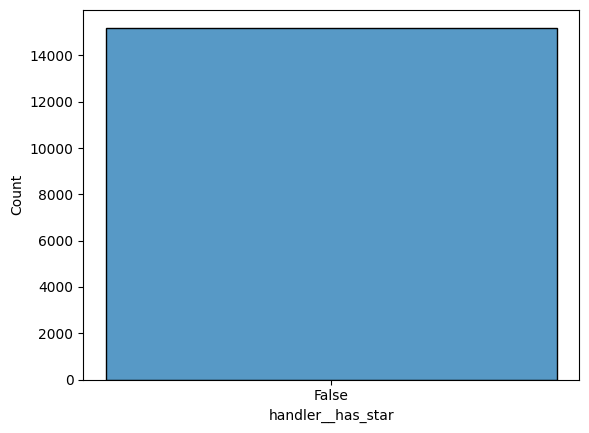

In [17]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['handler__has_star'], discrete=True)

In [18]:
num_true_values = len(X[X['handler__has_star'] == True])
num_false_values = len(X[X['handler__has_star'] == False])
std = X['handler__has_star'].std()
freq_true = len(X[X['handler__has_star'] == True]) / len(X['handler__has_star'])
freq_false = len(X[X['handler__has_star'] == False]) / len(X['handler__has_star'])
print(f'La variable has_star contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable has_star a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable has_star a False es {freq_false}.')

La variable has_star contiene 0 valores verdaderos y 15199 valores falsos. Y, la desviación típica es de 0.0
La frecuencia con la que programa puede tener la variable has_star a True es 0.0.
La frecuencia con la que programa puede tener la variable has_star a False es 1.0.


In [19]:
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'handler__has_star', possible_values)

La variable handler__has_star contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable handler__has_star toma el valor de 0.0 en un 100.0% de los items.
La variable handler__has_star toma el valor de True en un 0.0% de los items. [OUTLIER]


### IMPORTANTE 

No hay ningun try del tipo TryStar por lo que ninguna entrada toma el valor True para has_star

### Variable has_catch_all (4/5)
Esta variable es de tipo booleano y representa si el try tiene un except all.

<Axes: xlabel='handler__has_catch_all', ylabel='Count'>

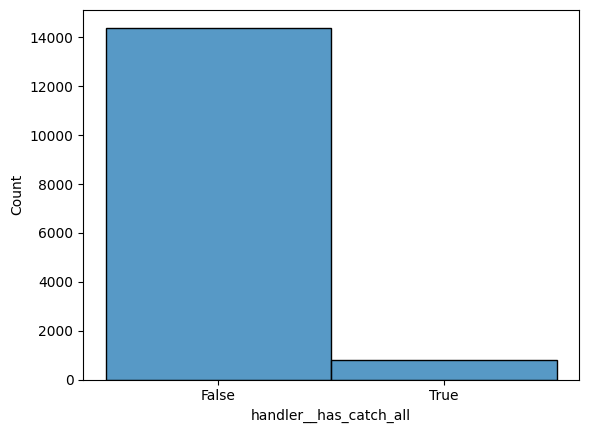

In [21]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['handler__has_catch_all'], discrete=True)

In [22]:
num_true_values = len(X[X['handler__has_catch_all'] == True])
num_false_values = len(X[X['handler__has_catch_all'] == False])
std = X['handler__has_catch_all'].std()
freq_true = len(X[X['handler__has_catch_all'] == True]) / len(X['handler__has_catch_all'])
freq_false = len(X[X['handler__has_catch_all'] == False]) / len(X['handler__has_catch_all'])
print(f'La variable has_catch_all contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable has_catch_all a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable has_catch_all a False es {freq_false}.')

La variable has_catch_all contiene 795 valores verdaderos y 14404 valores falsos. Y, la desviación típica es de 0.22265087068080902
La frecuencia con la que programa puede tener la variable has_catch_all a True es 0.05230607276794526.
La frecuencia con la que programa puede tener la variable has_catch_all a False es 0.9476939272320547.


In [23]:
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'handler__has_catch_all', possible_values)

La variable handler__has_catch_all contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable handler__has_catch_all toma el valor de 0.0 en un 94.77% de los items.
La variable handler__has_catch_all toma el valor de 1.0 en un 5.231% de los items.


In [24]:
X[X['handler__has_catch_all'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])


,handler__number_of_handlers,handler__has_star,handler__has_finally,handler__has_catch_all,handler__average_body_count,handler__expertise_level_BEGINNER,handler__expertise_level_EXPERT
count,795.000000,795.0,795.000000,795.0,795.000000,795.000000,795.000000
mean,1.069182,0.0,0.028931,1.0,1.558176,0.466667,0.533333
std,0.367432,0.0,0.167718,0.0,1.160825,0.499202,0.499202
min,1.000000,0.0,0.000000,1.0,1.000000,0.000000,0.000000
25%,1.000000,0.0,0.000000,1.0,1.000000,0.000000,0.000000
50%,1.000000,0.0,0.000000,1.0,1.000000,0.000000,1.000000
75%,1.000000,0.0,0.000000,1.0,2.000000,1.000000,1.000000
max,8.000000,0.0,1.000000,1.0,15.000000,1.000000,1.000000


### Variable has_finally (5/5)
Esta variable es de tipo booleano y representa si el Try tiene la clausula finally.

<Axes: xlabel='functiondef__is_private', ylabel='Count'>

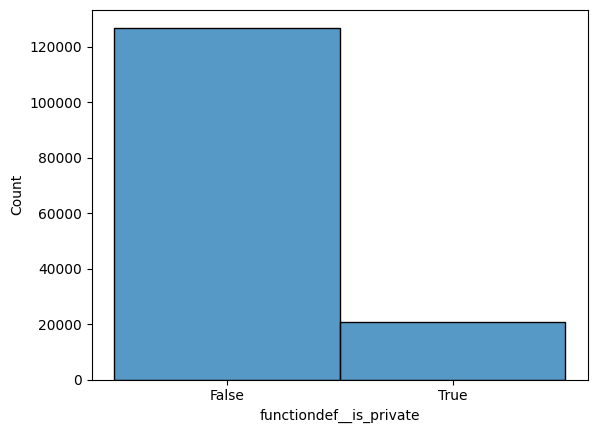

In [14]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['handler__has_finally'], discrete=True)

In [25]:
num_true_values = len(X[X['handler__has_finally'] == True])
num_false_values = len(X[X['handler__has_finally'] == False])
std = X['handler__has_finally'].std()
freq_true = len(X[X['handler__has_finally'] == True]) / len(X['handler__has_finally'])
freq_false = len(X[X['handler__has_finally'] == False]) / len(X['handler__has_finally'])
print(f'La variable has_finally contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable has_finally a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable has_finally a False es {freq_false}.')

La variable has_finally contiene 1295 valores verdaderos y 13904 valores falsos. Y, la desviación típica es de 0.2791926860809326
La frecuencia con la que programa puede tener la variable has_finally a True es 0.08520297387986052.
La frecuencia con la que programa puede tener la variable has_finally a False es 0.9147970261201395.


In [26]:
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'handler__has_finally', possible_values)

La variable handler__has_finally contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable handler__has_finally toma el valor de 0.0 en un 91.48% de los items.
La variable handler__has_finally toma el valor de 1.0 en un 8.52% de los items.


In [27]:
X[X['handler__has_finally'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])


,handler__number_of_handlers,handler__has_star,handler__has_finally,handler__has_catch_all,handler__average_body_count,handler__expertise_level_BEGINNER,handler__expertise_level_EXPERT
count,1295.000000,1295.0,1295.0,1295.000000,1295.000000,1295.000000,1295.000000
mean,0.224710,0.0,1.0,0.017761,0.305804,0.581467,0.418533
std,0.598562,0.0,0.0,0.132131,0.834861,0.493509,0.493509
min,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.0,1.0,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.0,1.0,0.000000,0.000000,1.000000,1.000000
max,8.000000,0.0,1.0,1.000000,10.000000,1.000000,1.000000
